In [46]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection, ensemble, metrics, decomposition, preprocessing
np.random.seed(0)

In [2]:
#Загрузка датасета, замена значений, удаление колонок
hr_data = pd.read_csv('C:\Pytorch\HR-Employee-Attrition.csv')
hr_data.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True)
hr_data['Attrition'].replace({'Yes': 1, 'No': 0}, inplace=True)
hr_data['Gender'].replace({'Male': 1, 'Female': 0}, inplace=True)
hr_data['OverTime'].replace({'Yes': 1, 'No': 0}, inplace=True)
hr_data = pd.get_dummies(hr_data)

In [3]:
#Создание train и test набора данных
X = hr_data.drop('Attrition', axis=1)
y = hr_data['Attrition']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.2, 
                                                                    random_state=0, stratify=y)
y_test.value_counts(normalize=True)

0    0.840136
1    0.159864
Name: Attrition, dtype: float64

In [34]:
#Пишем функции для построения ROC кривой, Feature_importances, confusion_matrix
#А также для отображения точности на кросс-валидации
def ROC_plot(clf, x):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(x)[:,1])
    roc_auc= metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='royalblue', lw=4, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
def FI_plot(clf):
    feats = {}
    for feature, importance in zip(X.columns, clf.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances[:10].reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='mediumpurple')
    plt.xlabel('Importance', fontsize=25, weight = 'bold')
    plt.ylabel('Features', fontsize=25, weight = 'bold')
    plt.title('Feature Importance (RandomForest)', fontsize=25, weight = 'bold')
    plt.show()
def CM_plot(clf):
    confusion_matrix = metrics.confusion_matrix(y_test, clf.predict(X_test))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
def cross_val_score(clf, X, y):
    print(f'Сross_val_score:{round(model_selection.cross_val_score(clf, X, y, cv=4).mean(), 3)}')

Сross_val_score:0.861


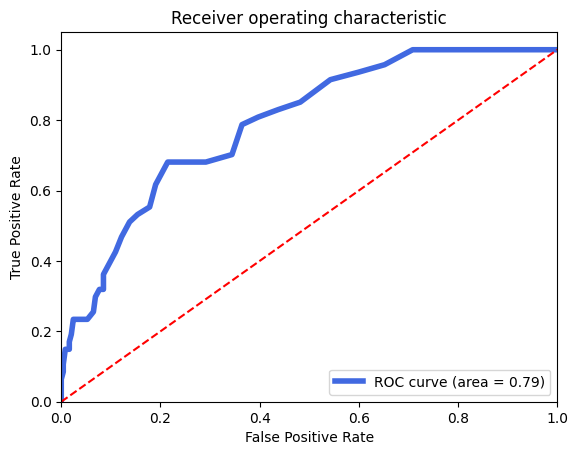

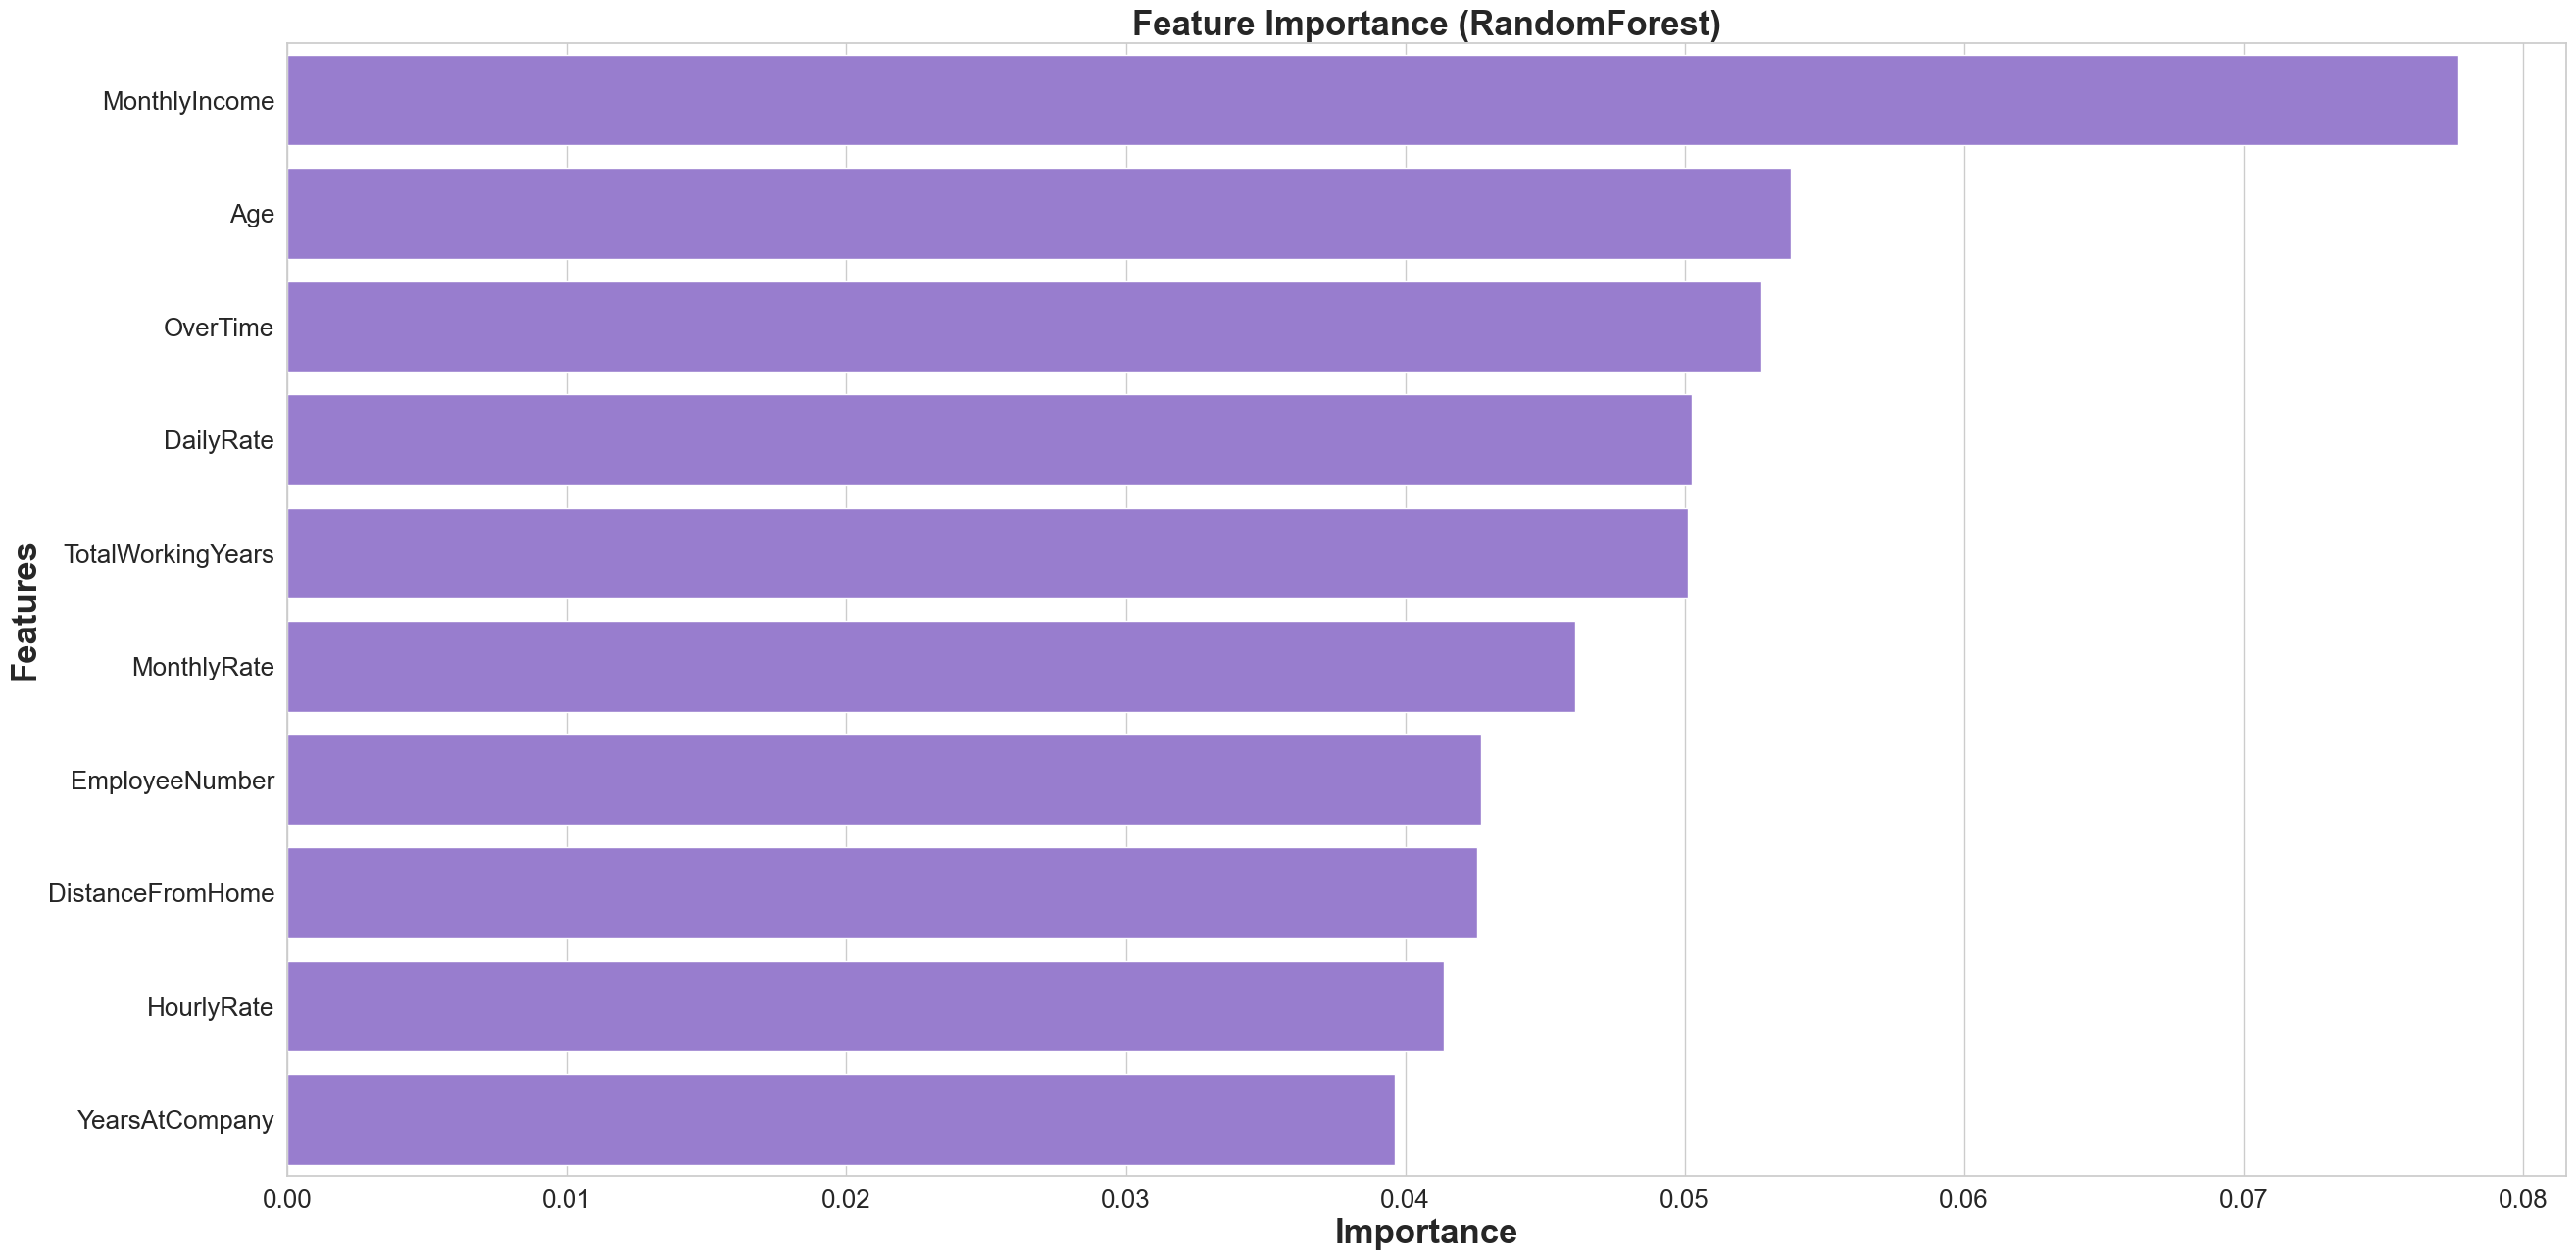

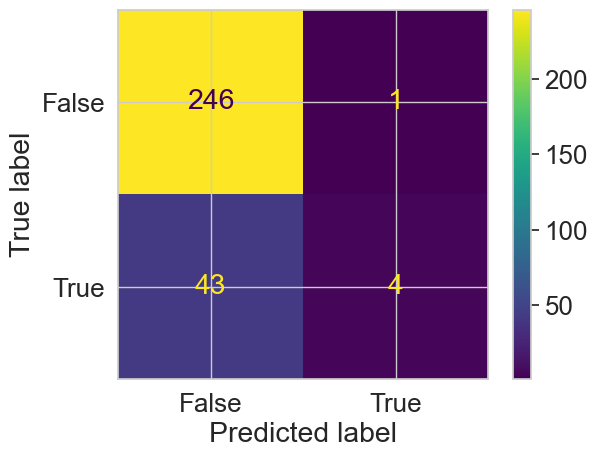

In [6]:
#RandomForest с базовыми гиперпараметрами
rf_clf = ensemble.RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
cross_val_score(rf_clf, X_train, y_train)
ROC_plot(rf_clf, X_test)
FI_plot(rf_clf)
CM_plot(rf_clf)

In [47]:
#Масштабирование данных: центрирование и стандартизация
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

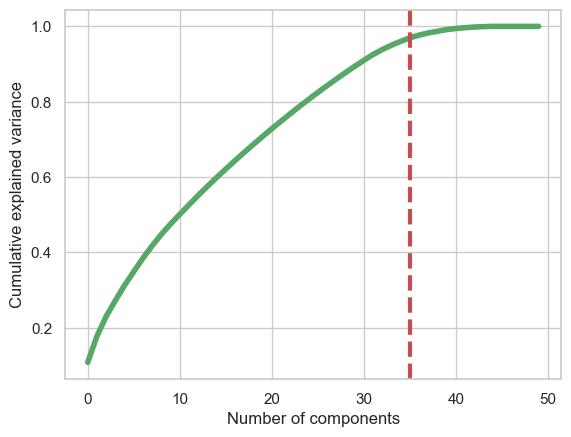

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.108116,0.108116
1,0.177761,0.069644
2,0.229919,0.052158
3,0.272415,0.042496
4,0.312633,0.040219
5,0.348988,0.036355
6,0.384866,0.035878
7,0.417488,0.032622
8,0.448083,0.030595
9,0.475380,0.027296


In [51]:
#PCA (Метод главных компонент)
pca_test = decomposition.PCA(n_components=50)
pca_test.fit(X_train_scaled)
sns.set_theme(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_), lw=4, color='g')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axvline(linewidth=3, color='r', linestyle = '--', x=35, ymin=0, ymax=1)
plt.show()
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
pca_df.head(38)

Сross_val_score:0.853


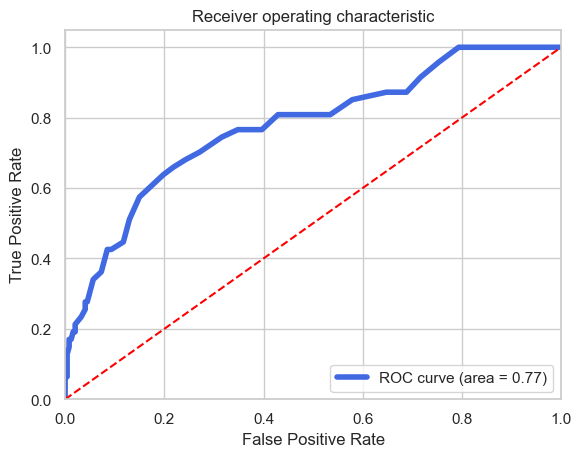

In [52]:
#RandomForest с базовыми параметрами + PCA
pca = decomposition.PCA(n_components=35)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
rf_clf_pca = ensemble.RandomForestClassifier(random_state=0)
rf_clf_pca.fit(X_train_scaled_pca, y_train)
cross_val_score(rf_clf_pca, X_train_scaled_pca, y_train)
ROC_plot(rf_clf_pca, X_test_scaled_pca)

In [36]:
n_estimators = range(30, 1000, 10)
max_depth = range(5, 80, 2)
min_samples_leaf = range(1, 30)
min_samples_split = range (1, 50)
paramiters = {'n_estimators': n_estimators, 'max_depth': max_depth, 
              'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}
rf_clf_1 = ensemble.RandomForestClassifier(random_state=0)
rs = model_selection.RandomizedSearchCV(rf_clf_1, paramiters, n_iter=2000, n_jobs=-1, cv=4, 
                                        verbose=1, random_state=0)
rs.fit(X_train_scaled_pca, y_train)
print(f'best_params {rs.best_params_}')
rf_clf_1_best = rs.best_estimator_
print(f'cross_val_score:{round(model_selection.cross_val_score(rf_clf_1_best, X_train_scaled_pca, y_train, cv=4).mean(), 3)}')

Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
best_params {'n_estimators': 790, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_depth': 79}
cross_val_score:0.855


In [37]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'split3_test_score',
            'std_test_score'],
            axis=1)
rs_df.rename(columns={'param_n_estimators': 'n_estimators', 'param_min_samples_split': 'min_samples_split',
                     'param_min_samples_leaf': 'min_samples_leaf', 'param_max_features': 'max_features',
                     'param_max_features': 'max_features', 'param_max_depth': 'max_depth', 
                     'mean_test_score': 'cross_val_score', 'rank_test_score': 'rank'}, inplace=True)
rs_df['cross_val_score'] = round(rs_df['cross_val_score'], 3)
rs_df.to_pickle("graph_data_pca.pkl")

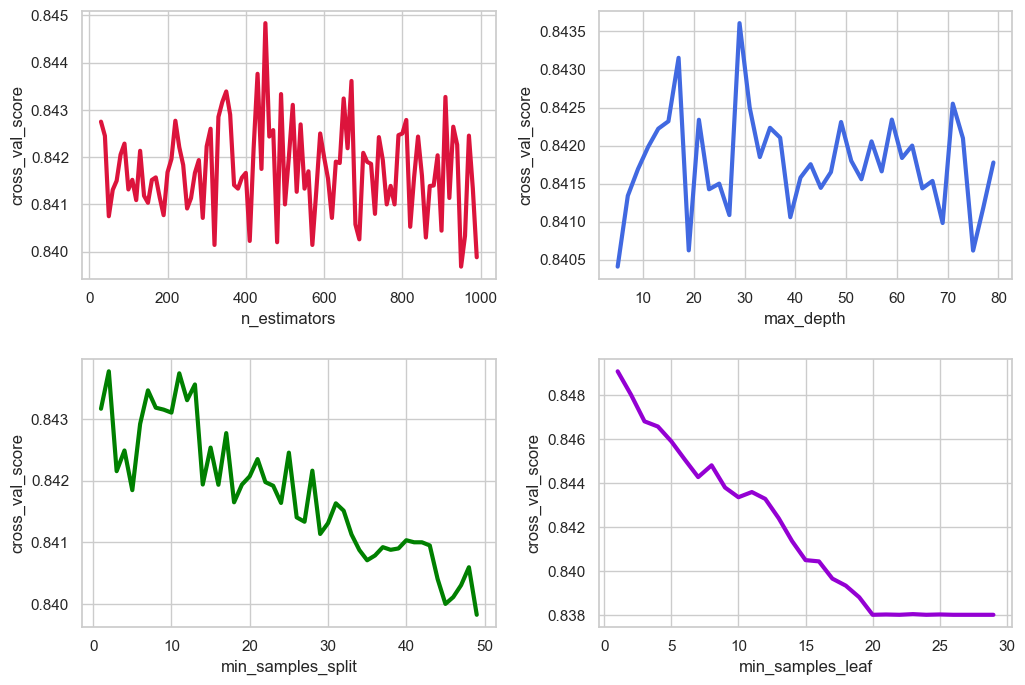

In [38]:
fig = plt.figure(figsize=[12, 8])
fig.subplots_adjust(hspace=0.3, wspace=0.25)
ax = fig.add_subplot(2, 2, 1)
sns.lineplot(data=rs_df, x='n_estimators', y='cross_val_score', errorbar=None, 
             linewidth = 3, color='crimson', ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.lineplot(data=rs_df, x='max_depth', y='cross_val_score', errorbar=None, 
             linewidth = 3, color='royalblue', ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.lineplot(data=rs_df, x='min_samples_split', y='cross_val_score', errorbar=None, 
             linewidth = 3, color='green', ax=ax)
ax = fig.add_subplot(2, 2, 4)
sns.lineplot(data=rs_df, x='min_samples_leaf', y='cross_val_score', errorbar=None, 
             linewidth = 3, color='darkviolet', ax=ax)
plt.show()

In [40]:
def define_best_param(label):
    data = rs_df[[label, 'cross_val_score']]
    mean_gb = data.groupby([label]).mean()
    mean_gb_sort = mean_gb.sort_values(by='cross_val_score', ascending=False)
    return list(mean_gb_sort.index[:5])
rs_df = pd.read_pickle("graph_data_pca_2000.pkl")
best_paramiters_by_rs = pd.DataFrame({'best_n_estimators': define_best_param('n_estimators'),
                                     'best_max_depth': define_best_param('max_depth'),
                                     'best_min_samples_split': define_best_param('min_samples_split'),
                                     'best_min_samples_leaf': define_best_param('min_samples_leaf'),})
best_paramiters_by_rs.to_pickle("my_data_pca.pkl")
best_paramiters_by_rs.head()

,best_n_estimators,best_max_depth,best_min_samples_split,best_min_samples_leaf
0,450,29,2,1
1,430,17,11,2
2,670,71,13,3
3,350,31,7,4
4,490,59,12,5


In [41]:
n_estimators = define_best_param('n_estimators')
max_depth = define_best_param('max_depth')
min_samples_leaf = define_best_param('min_samples_leaf')
min_samples_split = define_best_param('min_samples_split')
paramiters = {'n_estimators': n_estimators,
              'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 
              'min_samples_split': min_samples_split}
rf_clf_2 = ensemble.RandomForestClassifier(random_state=0)
gs = model_selection.GridSearchCV(rf_clf_2, paramiters, cv=4, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)
best_rf_clf_2 = gs.best_estimator_
print(f'best_params {gs.best_params_}')
print(f'cross_val_score:{round(model_selection.cross_val_score(best_rf_clf_2, X_train, y_train, cv=4).mean(), 3)}')

Fitting 4 folds for each of 625 candidates, totalling 2500 fits
best_params {'max_depth': 29, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 490}
cross_val_score:0.858


best_params {'max_depth': 29, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 490}
cross_val_score:0.858


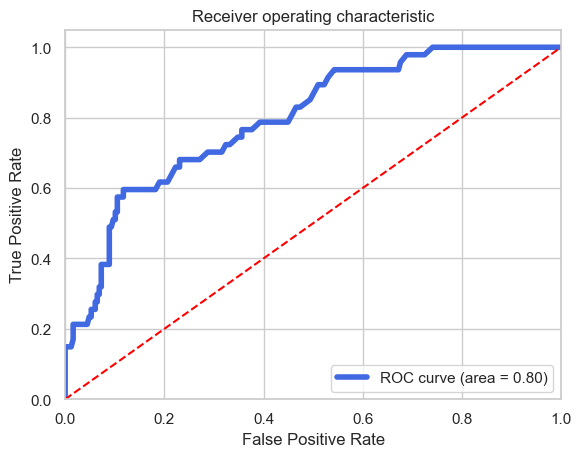

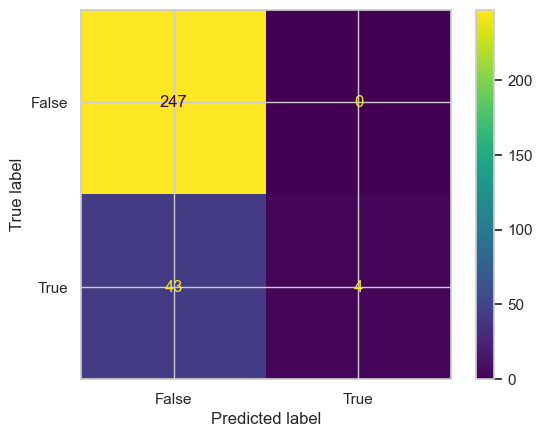

In [43]:
print(f'best_params {gs.best_params_}')
print(f'cross_val_score:{round(model_selection.cross_val_score(best_rf_clf_2, X_train, y_train, cv=4).mean(), 3)}')
ROC_plot(best_rf_clf_2, X_test)
CM_plot(best_rf_clf_2)

In [32]:
for i in range(1,51):
    pca = decomposition.PCA(n_components=i)
    pca.fit(X_train_scaled)
    X_train_scaled_pca = pca.transform(X_train_scaled)
    X_test_scaled_pca = pca.transform(X_test_scaled)
    rf_clf_pca = ensemble.RandomForestClassifier(n_estimators=40,
                                                 max_depth=29,
                                                 min_samples_split=9,
                                                 min_samples_leaf=3,
                                                random_state=0, n_jobs=-1)
    rf_clf_pca.fit(X_train_scaled_pca, y_train)
    score = rf_clf_pca.score(X_train_scaled_pca, y_train)
    cross_val_score = round(model_selection.cross_val_score(
        rf_clf_pca, X_train_scaled_pca, y_train, cv=4).mean(), 3)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_clf_pca.predict_proba(X_test_scaled_pca)[:,1])
    roc_auc= metrics.auc(fpr, tpr)
    print(f'Number: {i} Score: {score}, cross_val_score: {cross_val_score}, auc: {roc_auc}')

Number: 1 Score: 0.8690476190476191, cross_val_score: 0.825, auc: 0.6025066758549401
Number: 2 Score: 0.8818027210884354, cross_val_score: 0.836, auc: 0.6525540528899991
Number: 3 Score: 0.8809523809523809, cross_val_score: 0.842, auc: 0.7005340683952107
Number: 4 Score: 0.9064625850340136, cross_val_score: 0.84, auc: 0.6793866827461452
Number: 5 Score: 0.9056122448979592, cross_val_score: 0.838, auc: 0.6954948746662072
Number: 6 Score: 0.907312925170068, cross_val_score: 0.841, auc: 0.6872254285468171
Number: 7 Score: 0.9064625850340136, cross_val_score: 0.843, auc: 0.7001033680764922
Number: 8 Score: 0.9013605442176871, cross_val_score: 0.843, auc: 0.667499353949522
Number: 9 Score: 0.9132653061224489, cross_val_score: 0.848, auc: 0.6673270738220346
Number: 10 Score: 0.9158163265306123, cross_val_score: 0.843, auc: 0.7058316823154449
Number: 11 Score: 0.9124149659863946, cross_val_score: 0.849, auc: 0.6848565767938668
Number: 12 Score: 0.9124149659863946, cross_val_score: 0.846, auc: